# <center>Forecast Future Sales    </center>

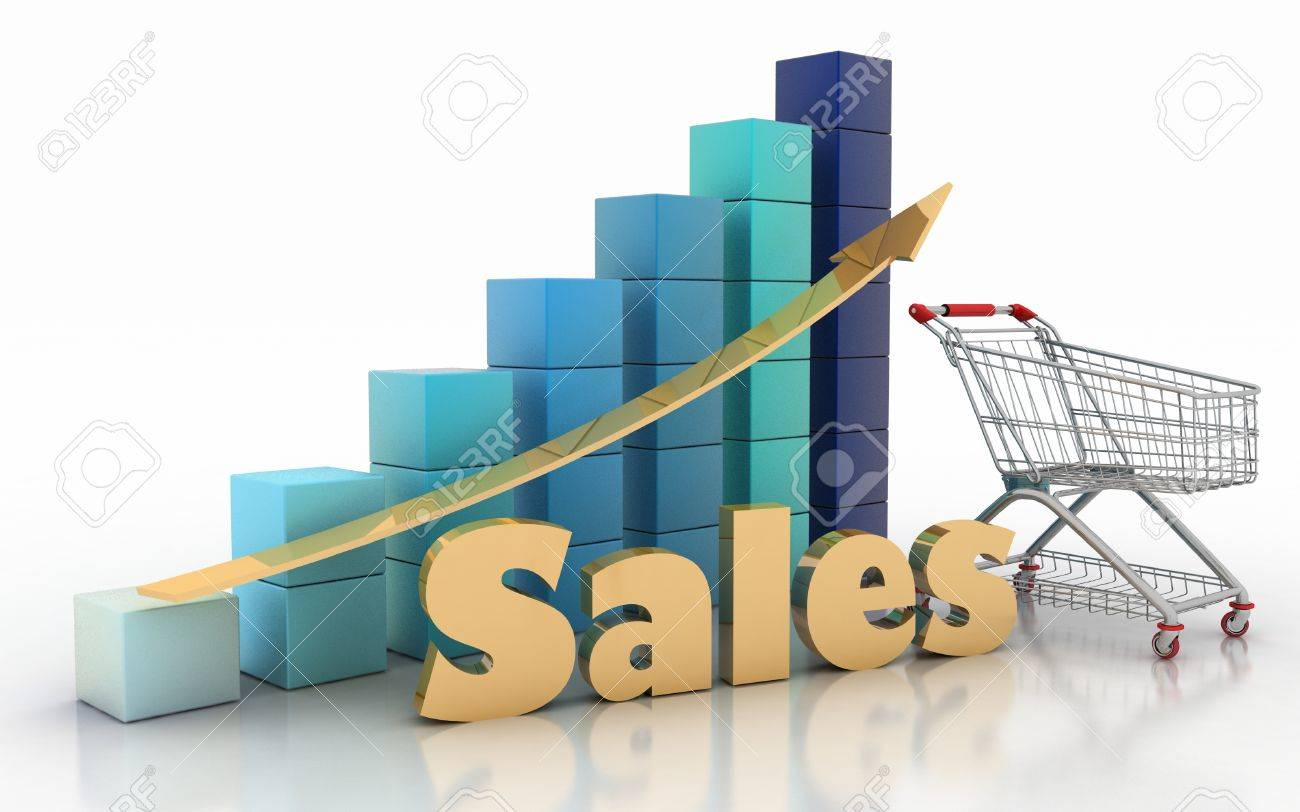

#### The notebook is classified to the following sections:
<a href='#the_destination_1'>1. Problem Statement</a><br>
<a href='#the_destination_2'>2. Import Data</a><br>
-   <a href='#the_destination_2.1'>2.1 Data Dictionary</a><br>

<a href='#the_destination_3'>3. Exploratory Data Analysis (EDA)</a><br>
<a href='#the_destination_4'>4. Exploring the target</a><br>
<a href='#the_destination_5'>5. Detecting Outliers</a><br>
<a href='#the_destination_6'>6. Feature Engineering</a><br>
-   <a href='#the_destination_6.1'>6.1 merging test with train</a><br>

<a href='#the_destination_7'>7 Fill lags missing values</a><br>
<a href='#the_destination_8'>8. visualization</a><br>
<a href='#the_destination_9'>9. Dummies</a><br>

<a href='#the_destination_10'>10. Modeling</a>

   -   <a href='#the_destination_10.1'>10.1 Xgboost</a>

   -   <a href='#the_destination_10.2'>10.2 Sequential model</a>

   -   <a href='#the_destination_10.3'>10.3 LSTM</a>

   -   <a href='#the_destination_10.4'>10.4 Random Forest Regressor Model</a>

   -   <a href='#the_destination_10.5'>10.5 LinearRegression</a>

   -   <a href='#the_destination_10.6'>10.6 Ridge</a>

   -   <a href='#the_destination_10.7'>10.7 Build Logistic Regression Model</a>

          

<a href='#the_destination_11'>11. Submission</a><br>
<a href='#the_destination_13'>12. Evaluation</a><br>
<a href='#the_destination_13'>13. Conclusion and Recommendations</a><br>
<a href='#the_destination_14'>14. References</a><br>

<a id='the_destination_1'></a>
# 1. Problem Statement

We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Notice that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

<br><br><br>**To use tensorflow in CPU uncomment the code below, And for GPU leave it commented**

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
# import tensorflow as tf

In [4]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

<a id='the_destination_2'></a>
**import required libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge , LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import tensorflow as tf
import time

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


<a id='the_destination_2'></a>
# 2. Importing Datasets

In [2]:
df_sales_train0 = pd.read_csv('Datasets/sales_train.csv')
test = pd.read_csv('Datasets/test.csv')
df_shops = pd.read_csv('Datasets/shops_en.csv')
df_items = pd.read_csv('Datasets/items_en.csv')
df_catog = pd.read_csv('Datasets/item_categories_en.csv')
df = pd.read_csv('Datasets/sample_submission.csv')

<a id='the_destination_2.1'></a>
#### 2.1 Data Dictionary

|Feature|Dataset|Description|
|-------|---|---|
|ID|test|an Id that represents a (Shop, Item) tuple within the test set.| 
|Shop_id|df_shops/test/df_sales_train0|unique identifier of a shop.| 
|item_id|df_items/test/df_sales_train0|unique identifier of a product.| 
|item_category_id |df_catog/df_sales_train0/df_items|unique identifier of item category.| 
|item_cnt_day|df_sales_train0|number of products sold. You are predicting a monthly amount of this measure.| 
|item_price|df_sales_train0|current price of an item.| 
|date|df_sales_train0|date in format dd/mm/yyyy.| 
|date_block_num|df_sales_train0|a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33.| 
|item_name|df_sales_train0/df_items|name of item.|
|shop_name|df_sales_train0/df_shops|name of shop.|
|item_category_name|df_sales_train0/df_catog|name of item category.|

<a id='the_destination_3'></a>
# 3. EDA

In [8]:
display(df_sales_train0.head())
df_sales_train0.shape

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

(2935849, 6)

In [9]:
df_sales_train0['date_block_num'].nunique()

34

In [10]:
df_sales_train0['shop_id'].nunique()

60

In [11]:
df_sales_train0['item_id'].nunique()

21807

In [12]:
df_catog.head()

item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4

In [13]:
df_catog['item_category_name'].nunique()

84

In [14]:
df_items.head()

item_name  item_id  \
0                       ! POWER IN glamor (PLAST.) D        0   
1  ! ABBYY FineReader 12 Professional Edition Ful...        1   
2                           *** In the glory (UNV) D        2   
3                             *** BLUE WAVE (Univ) D        3   
4                                  *** BOX (GLASS) D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [15]:
df_items['item_name'].nunique()

22155

In [16]:
df_shops.head()

shop_name  shop_id
0  ! Yakutsk Ordzhonikidze, 56 Franc        0
1       ! Yakutsk TC "Central" Franc        1
2                   Adygea TC "Mega"        2
3   Balashikha TRC "October-Kinomir"        3
4         Volzhsky mall "Volga Mall"        4

In [17]:
df_shops['shop_name'].nunique()

60

In [18]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [19]:
df.head()

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5

In [20]:
df_sales_train0.shape

(2935849, 6)

<a id='the_destination_4'></a>
# 4. Exploring the target

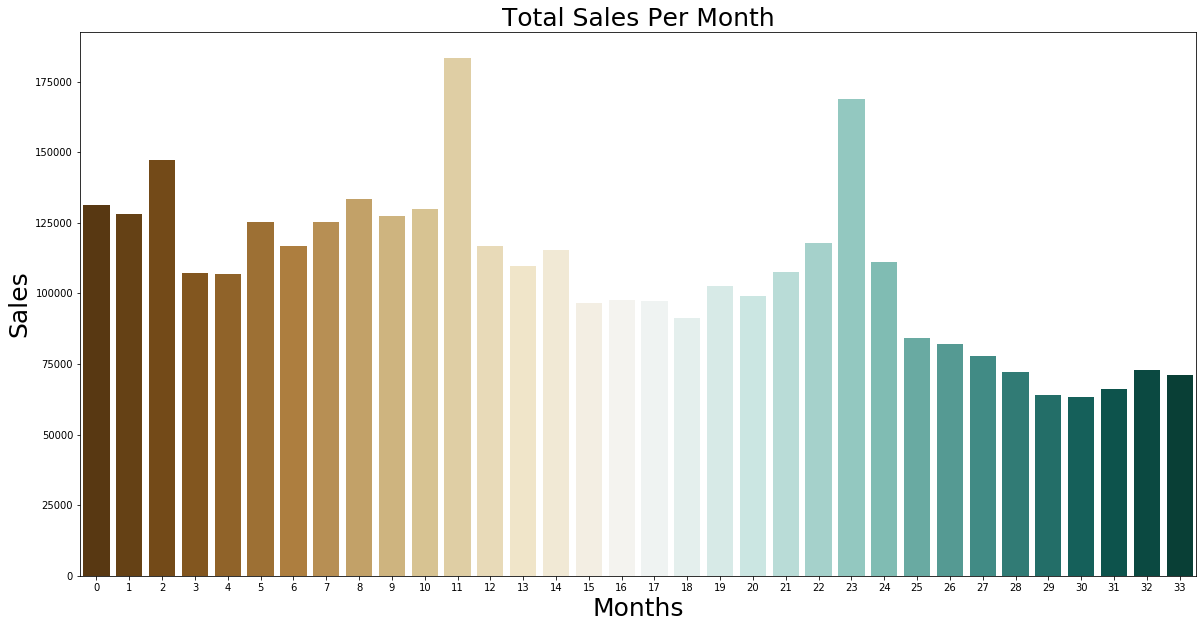

In [27]:
#this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

Z = df_sales_train0.groupby('date_block_num').agg({'item_cnt_day': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_cnt_day', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);


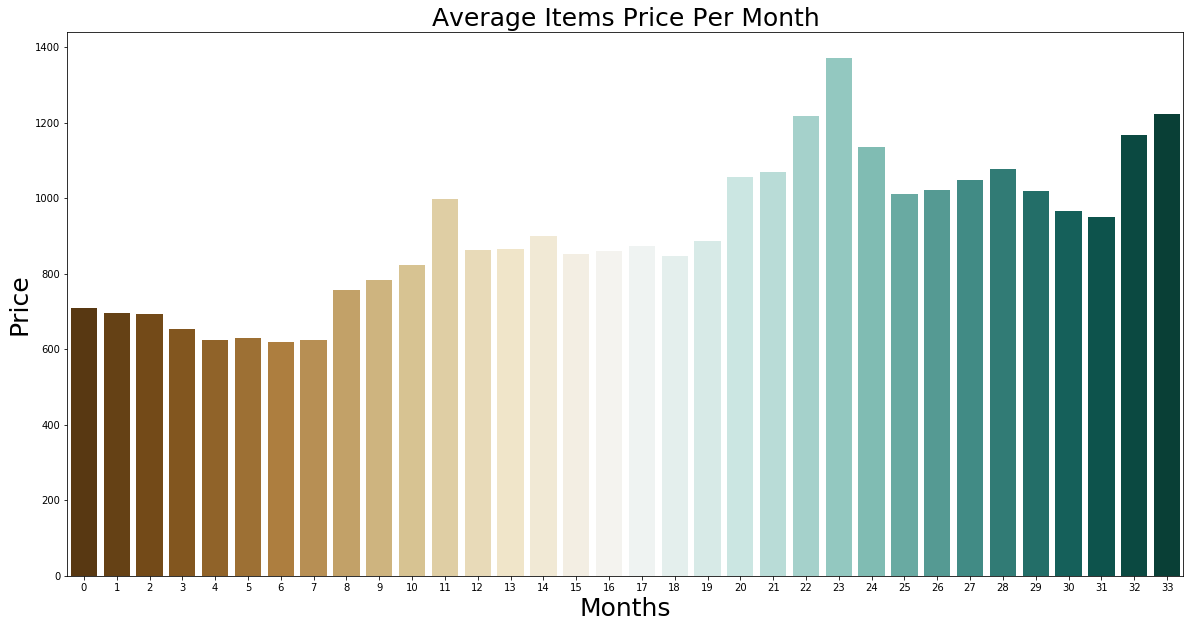

In [28]:
#also this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

price_per_month = df_sales_train0.groupby('date_block_num').agg({'item_price': 'mean'}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=price_per_month, x='date_block_num', y='item_price', ax = ax, palette="BrBG")
plt.title('Average Items Price Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Price', fontsize=25);

<a id='the_destination_5'></a>
### 5. Detecting Outliers

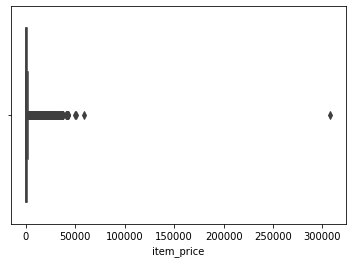

In [23]:
sns.boxplot(df_sales_train0['item_price'])

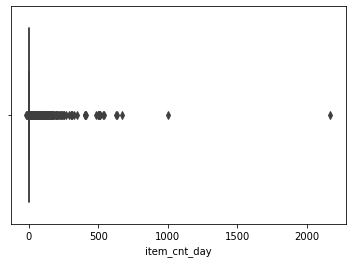

In [24]:
sns.boxplot(df_sales_train0['item_cnt_day'])

In [25]:
#removing item_cnt_day bigger than 1001 and item_price bigger than 100000
df_sales_train0 = df_sales_train0[df_sales_train0['item_cnt_day'] < 1001]
df_sales_train0 = df_sales_train0[df_sales_train0['item_price'] < 100000]

<a id='the_destination_6'></a>

# 6. Feature Engineering

Gathering all combinations of : [date_block_num , shop_id , item_id] because we will transform our data from daily to monthly

In [26]:
from itertools import product
df_sales_train = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_sales_train0[df_sales_train0['date_block_num'] == i]
    df_sales_train.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
    
df_sales_train = pd.DataFrame(np.vstack(df_sales_train), columns=cols)

Create a 'revenue' column from multiplying 'item_price' with 'item_cnt_day'

In [27]:
df_sales_train0['revenue'] = df_sales_train0['item_price'] *  df_sales_train0['item_cnt_day']

transform our data from daily to monthly by using grouby 

In [28]:
agg = df_sales_train0.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
agg.columns = ['item_cnt_month']
agg.reset_index(inplace=True)
merge1 = pd.merge(df_sales_train, agg, on=cols, how='left')

Create a 'date_block_num' column in test dataset, And all of it will be 34 because all the test data in the same month 

In [29]:
test['date_block_num'] = 34

<a id='the_destination_6.1'></a>

#### 6.1 merging test with train

Here we are filtering the train data to only keep 'shop_id' and 'item_id' that exist in test data

In [31]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
merge1 = merge1[merge1['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
merge1 = merge1[merge1['item_id'].isin(test_item_ids)]
merge1.reset_index(inplace=True, drop=True)

Here we are merging train and test data 

In [32]:
merge1 = pd.concat([merge1, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merge1.fillna(0, inplace=True)

Merging our dataframe with shops and items and categories datasets 

In [33]:
merge1 = pd.merge(merge1, df_shops, on=['shop_id'], how='left')
merge1 = pd.merge(merge1, df_items, on=['item_id'], how='left')
merge1 = pd.merge(merge1, df_catog, on=['item_category_id'], how='left')

Correct duplicate values

In [34]:
merge1.loc[merge1.shop_id == 0, 'shop_id'] = 57
merge1.loc[merge1.shop_id == 1, 'shop_id'] = 58
merge1.loc[merge1.shop_id == 10, 'shop_id'] = 11

Because the data in time series structure, Here we are creating a function which will create a lag columns to see how the data changes from time to time

In [35]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [36]:
merge1 = lag_feature(merge1, [1,2,3,6,12], 'item_cnt_month')  # Create months lags

This data gathered from russian stores, So here we are adding a new column 'CPI_inflation' which contains monthly CPI inflation in russia from 2013 to the end of 2015 (CPI: Consumer price index)<br>

In [37]:
CPI_inflation = [0.97,0.56,0.34,0.51,0.66,0.42,0.82,0.14,0.21,0.57,0.57,0.50,
                 0.59,0.70,1.02,0.90,0.90,0.62,0.49,0.24,0.65,0.82,1.28,2.62,
                 3.85,2.22,1.21,0.46,0.35,0.19,0.80,0.35,0.57,0.74,0.75]
merge1['CPI_inflation'] = 0
for i, value in enumerate(CPI_inflation):
    merge1['CPI_inflation'][merge1['date_block_num'] == i ] = value

merge1 = lag_feature(merge1, [1,2,3,6,12], 'CPI_inflation')  # Creating lags for CPI_inflation

Create a new column "date_avg_item_cnt" wich will take the average of all items sales per month

In [38]:
agg = merge1.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num'], how='left')
merge1 = lag_feature(merge1, [1], 'date_avg_item_cnt')
# merge1.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Create a new column "date_item_avg_item_cnt" wich will take the average for each item sales per month 

In [39]:
agg = merge1.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_item_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
merge1 = lag_feature(merge1, [1,2,3,6,12], 'date_item_avg_item_cnt')
# merge1.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Create a new column "date_shop_avg_item_cnt" wich will take the average for each shop sales per month 

In [40]:
agg = merge1.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_shop_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','shop_id'], how='left')
merge1 = lag_feature(merge1, [1,2,3,6,12], 'date_shop_avg_item_cnt')
# merge1.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


Create a new column "date_cat_avg_item_cnt" wich will take the average for each category sales per month 

In [41]:
agg = merge1.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_cat_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_category_id'], how='left')
merge1 = lag_feature(merge1, [1], 'date_cat_avg_item_cnt')
# merge1.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)


Create a new column "date_shop_cat_avg_item_cnt" wich will take the average for each shop with category sales per month 

In [42]:
agg = merge1.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
agg.columns = ['date_shop_cat_avg_item_cnt']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
merge1 = lag_feature(merge1, [1], 'date_shop_cat_avg_item_cnt')
# merge1.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)


Create a new column "item_avg_item_price" wich will take the average price for each item 

In [43]:
agg =df_sales_train0.groupby(['item_id']).agg({'item_price': ['mean']})
agg.columns = ['item_avg_item_price']
agg.reset_index(inplace=True)
merge1 = pd.merge(merge1, agg, on=['item_id'], how='left')

Create a new column "date_item_avg_item_price" wich will take the average price for each item per month

In [44]:
agg = df_sales_train0.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
agg.columns = ['date_item_avg_item_price']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
lags = [1,2,3,4,5,6]
merge1 = lag_feature(merge1, lags, 'date_item_avg_item_price')

Create a new lag columns which will contains the percent of the difference between average item price in lag months and average price for each item 

In [45]:
for i in lags:
    merge1['delta_price_lag_'+str(i)] = \
        (merge1['date_item_avg_item_price_lag_'+str(i)] - merge1['item_avg_item_price']) / merge1['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
merge1['delta_price_lag'] = merge1.apply(select_trend, axis=1)
merge1['delta_price_lag'].fillna(0, inplace=True)

we don't need all lags columns we create it to get delta here we will drop it 

In [46]:
fetures_to_drop = []
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

merge1.drop(fetures_to_drop, axis=1, inplace=True)


Create a new column "date_shop_revenue" wich will take the sum of revenue for each shop per month

In [47]:
agg = df_sales_train0.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
agg.columns = ['date_shop_revenue']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','shop_id'], how='left')

Create a new column "date_shop_revenue" wich will take the avreage of revenue for each shop

In [48]:
agg = merge1.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
agg.columns = ['shop_avg_revenue']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['shop_id'], how='left')

Create a new lag columns which will contains the percent of the difference between average shop revenue in lag months and sum of revenue for each shop per month

In [49]:
merge1['delta_revenue'] = (merge1['date_shop_revenue'] - merge1['shop_avg_revenue']) / merge1['shop_avg_revenue']

merge1 = lag_feature(merge1, [1], 'delta_revenue')


Create a new column "month" wich will take month number from date_block_num

In [51]:
merge1['month'] = merge1['date_block_num'] % 12

Create a new column "days" wich will take Number of days in a month. 
There are no leap years.



In [52]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
merge1['days'] = merge1['month'].map(days)

Create a new column "item_shop_last_sale" which will count duration since last sale for each item and shop

In [53]:
cache = {}
merge1['item_shop_last_sale'] = -1
for idx, row in merge1.iterrows():    
    key = str(row['item_id'])+' '+str(row['shop_id'])
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        merge1.at[idx, 'item_shop_last_sale'] = row['date_block_num'] - last_date_block_num
        cache[key] = row['date_block_num']  

Create a new column "item_last_sale" which will count duration since last sale for each item

In [54]:
cache = {}
merge1['item_last_sale'] = -1
for idx, row in merge1.iterrows():    
    key = row['item_id']
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        if row['date_block_num']>last_date_block_num:
            merge1.at[idx, 'item_last_sale'] = row['date_block_num'] - last_date_block_num
            cache[key] = row['date_block_num']   

Create a new columns :
-   "item_shop_first_sale" which will count duration since first sale for each item and shop

-   "item_first_sale" which will count duration since first sale for each item 

In [55]:
merge1['item_shop_first_sale'] = merge1['date_block_num'] - merge1.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
merge1['item_first_sale'] = merge1['date_block_num'] - merge1.groupby('item_id')['date_block_num'].transform('min')

This data gathered from russian stores, So here we are adding a new column 'gdp' which contains yearly gdp in russia from 2013 to the end of 2015 (gdp: Gross domestic product)<br>


In [56]:
merge1['gdp'] = 0
merge1['gdp'][merge1['date_block_num'] < 25 ] = 14101
merge1['gdp'][merge1['date_block_num'] > 24 ] = 9314

<a id='the_destination_7'></a>

### 7. Fill lags missing values

In [57]:
merge1.isnull().sum().sum()

21456419

In [58]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            elif('CPI_inflation' in col):
                df[col].fillna(0, inplace=True)        
    return df

In [59]:
merge1 = fill_na(merge1)

Our data is too big so to save memory and modeling time we will change types for all columns 

In [4]:
for col in merge1.columns:
    if col == 'date_shop_revenue':
        merge1[col] = merge1[col].astype('float64')
    elif merge1[col].dtype == 'float64':
        merge1[col] = merge1[col].astype('float16')
    elif col == 'item_id':
        merge1[col] = merge1[col].astype('int16')
    elif merge1[col].dtype == 'int64':
        merge1[col] = merge1[col].astype('int8')
    

In [62]:
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988638 entries, 0 to 2988637
Data columns (total 52 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   date_block_num                    int8   
 1   shop_id                           int8   
 2   item_id                           int16  
 3   item_cnt_month                    float16
 4   ID                                float16
 5   shop_name                         object 
 6   item_name                         object 
 7   item_category_id                  int8   
 8   item_category_name                object 
 9   item_cnt_month_lag_1              float16
 10  item_cnt_month_lag_2              float16
 11  item_cnt_month_lag_3              float16
 12  item_cnt_month_lag_6              float16
 13  item_cnt_month_lag_12             float16
 14  CPI_inflation                     float16
 15  CPI_inflation_lag_1               float16
 16  CPI_inflation_lag_2               fl

all the first words in shop names contains city names so here we will fix spaces and special characters

In [63]:
merge1['shop_name'].unique()

array(['Yaroslavl shopping center "Altair"', 'Moscow TRC "Atrium"',
       'Moscow TK "Budenovsky" (pav.K7)', 'Kursk TC "Pushkin"',
       'Moscow Shop C21', 'Krasnoyarsk SC "June"',
       'Moscow MTRTS "Afi Mall"',
       'Moscow shopping center "MEGA Teply Stan" II of',
       'Moscow shopping mall "area" (Belyaevo)',
       'Volzhsky mall "Volga Mall"', 'Voronezh (Plekhanovskaya, 13)',
       'Adygea TC "Mega"', 'Balashikha TRC "October-Kinomir"',
       'Voronezh TRC "Maksimir"', 'Kolomna TC "Rio"',
       'Kaluga SEC "XXI Century"', 'Zhukovsky Street. Chkalov 39m?',
       'Kazan shopping mall of "Parkhouse" II of',
       'Shop Online Emergencies', 'Ufa TC "Family" 2',
       'Moscow shopping center "Semyonov"',
       'Nizhny Novgorod SEC "Fantasy"', 'Czechs SEC "Carnival"',
       'Surgut SEC "City Mall"', 'Tyumen SC "Goodwin"',
       'St. Petersburg TK "Nevsky Center"', 'Ufa TC "Central"',
       'RostovNaDonu TC "Mega"', 'Omsk TC "Mega"', 'Samara TC "Melody"',
       'Novos

In [64]:
merge1['shop_name'].replace('! Yakutsk Ordzhonikidze, 56 Franc' , 'Yakutsk Ordzhonikidze, 56' , inplace=True) 
merge1['shop_name'].replace('! Yakutsk TC "Central" Franc' , 'Yakutsk TC "Central"' , inplace=True) 
merge1['shop_name'].replace('St. Petersburg TK "Nevsky Center"' , 'Petersburg TK "Nevsky Center"' , inplace=True) 
merge1['shop_name'].replace('Shop Online Emergencies' , 'online Shop Emergencies' , inplace=True) 
merge1['shop_name'].replace('Digital storage 1C-line' , 'online Digital storage 1C-line' , inplace=True)
merge1['shop_name'].replace('Zhukovsky Street. Chkalov 39m?' , 'Zhukovsky Street. Chkalov 39m²' , inplace=True)

Create a new column "city" from the first word in shop names

In [65]:
merge1['city'] = merge1['shop_name'].str.split(' ').map(lambda x: x[0])

Create a new columns : 
 - "category_type" which will extract category_type from item_category_name
 - "category_subtype" which will extract category_subtype from item_category_name

In [67]:
merge1['item_category_name'].unique()

array(['Movies - Blu-Ray', 'Music - CD of local production',
       'Games PC - Standard Edition', 'Music - Vinyl', 'Games - XBOX 360',
       'Books - Methodical materials 1C', 'Program - For home and office',
       'Games - PSP', 'Games - PS3', 'Gifts - Development',
       'Program - 1C: Enterprise 8', 'Music - MP3',
       'Music - Gift Edition', 'Games PC - Additional publications',
       'Accessories - PS3', 'Accessories - PSVita', 'Payment cards - PSN',
       'Music - CD production firm', 'Games - PSVita',
       'Movies - Blu-Ray 3D', 'Accessories - XBOX 360', 'Movie - DVD',
       'Books - Audiobooks 1C', 'Program - Educational',
       'Books - Audiobooks', 'Cinema - Collector', 'Gifts - Souvenirs',
       'Gifts - gadgets, robots, sports', 'System Tools',
       'Gifts - Board Games', 'Gifts - Games (compact)',
       'Gifts - Soft Toys', 'batteries', 'Gifts - Figures',
       'Delivery of goods', "Games PC - Collector's Edition",
       'Gifts - Bags, Albums, Mats d / mo

In [68]:
merge1['split'] = merge1['item_category_name'].str.split('-')
merge1['category_type'] = merge1['split'].map(lambda x: x[0].strip())
merge1['category_subtype'] = merge1['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
merge1.drop(columns=['item_category_name' , 'split'] , inplace=True , axis=1)

fix spelling 

In [69]:
merge1['category_subtype'].replace('Blu','BluRay' , inplace=True)
merge1['category_type'].replace('Movies','Movie' , inplace=True)

In [70]:
merge1['category_type'].unique()

array(['Movie', 'Music', 'Games PC', 'Games', 'Books', 'Program', 'Gifts',
       'Accessories', 'Payment cards', 'Cinema', 'System Tools',
       'batteries', 'Delivery of goods', 'Programs', 'Game consoles',
       'Игры', 'Games Android', 'Payment card', 'PC', 'Games MAC'],
      dtype=object)

In [71]:
merge1['category_subtype'].unique()

array(['BluRay', 'CD of local production', 'Standard Edition', 'Vinyl',
       'XBOX 360', 'Methodical materials 1C', 'For home and office',
       'PSP', 'PS3', 'Development', '1C: Enterprise 8', 'MP3',
       'Gift Edition', 'Additional publications', 'PSVita', 'PSN',
       'CD production firm', 'DVD', 'Audiobooks 1C', 'Educational',
       'Audiobooks', 'Collector', 'Souvenirs', 'gadgets, robots, sports',
       'System Tools', 'Board Games', 'Games (compact)', 'Soft Toys',
       'batteries', 'Figures', 'Delivery of goods', "Collector's Edition",
       'Bags, Albums, Mats d / mouse', 'Attributes', 'Digital',
       'Home & Office (Digital)', 'Educational (figure)',
       'Souvenirs (weighed in)', 'PS4', 'Audiobooks (figure)',
       'Accessories for games', 'Live!', 'Live! (Numeral)', 'XBOX ONE',
       'Comics, Manga', 'artbook, encyclopedia', 'Windows (figure)',
       'MAC (figure)', 'Headsets / Headphones'], dtype=object)

### Saving the data  after we fineshed feature engineering 

In [72]:
merge1.to_csv('merge1_Nodummies.csv')

**Importing the dataset**

In [8]:
merge1 = pd.read_csv('merge1_Nodummies.csv' , index_col='Unnamed: 0')

In [3]:
merge1_Nodummies = pd.read_csv('merge1_Nodummies.csv' , index_col='Unnamed: 0')

<a id='the_destination_8'></a>

# 8. Visualization

filter our data to select only sales for visualization

In [4]:
merge1_Nodummies = merge1_Nodummies[merge1_Nodummies['date_block_num'] < 34]
merge1_Nodummies = merge1_Nodummies[merge1_Nodummies['item_cnt_month'] > 0]


Monthly Sales per category type 

In [5]:
import plotly.express as px
pie_fig = merge1_Nodummies.groupby('category_type').agg({'item_cnt_month': sum}).\
sort_values(by='item_cnt_month',ascending=False).reset_index()
fig = px.pie(pie_fig, values='item_cnt_month', names='category_type', title='Percentage of Sales Per Category')
fig.show()

In [6]:
import plotly.express as px
sub_pie = merge1_Nodummies.groupby('category_subtype').agg({'item_cnt_month': sum}).\
sort_values(by='item_cnt_month',ascending=False).reset_index()
fig = px.pie(sub_pie, values='item_cnt_month', names='category_subtype', title='Percentage of Sales Per Sub Category')
fig.show()

--------------------

Monthly Sales per category type 

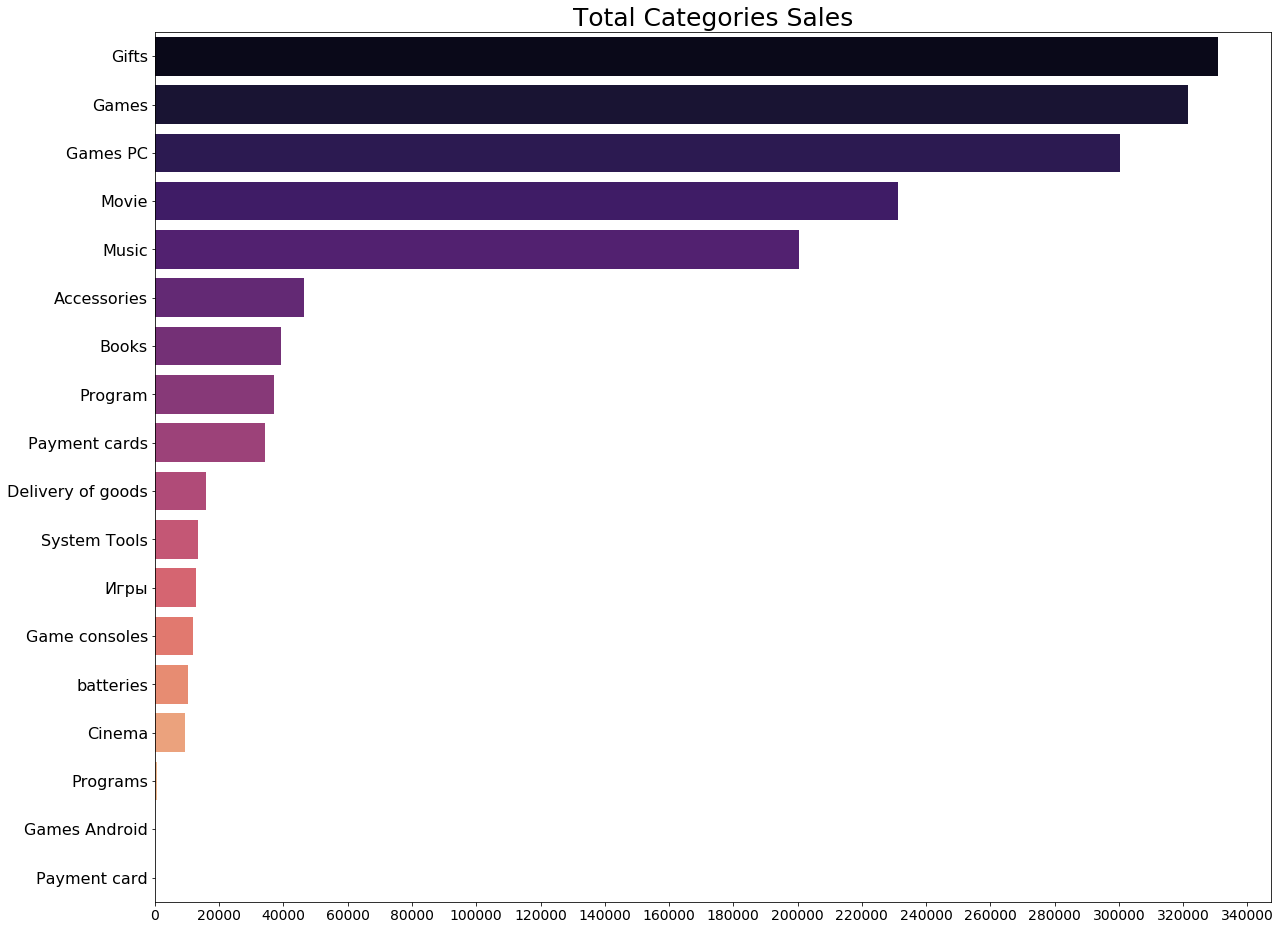

In [21]:
Z = merge1_Nodummies.groupby('category_type').agg({'item_cnt_month': sum}).sort_values(by='item_cnt_month',ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,16))
sns.barplot(data=Z, x='item_cnt_month', y='category_type', palette="magma",orient='h')
plt.yticks()
plt.ylabel('')
plt.xlabel('')
plt.title('Total Categories Sales', fontsize=25)
plt.xticks([i for i in range(0, 350000, 20000)], fontsize=14);

Monthly Sales per category subtype 

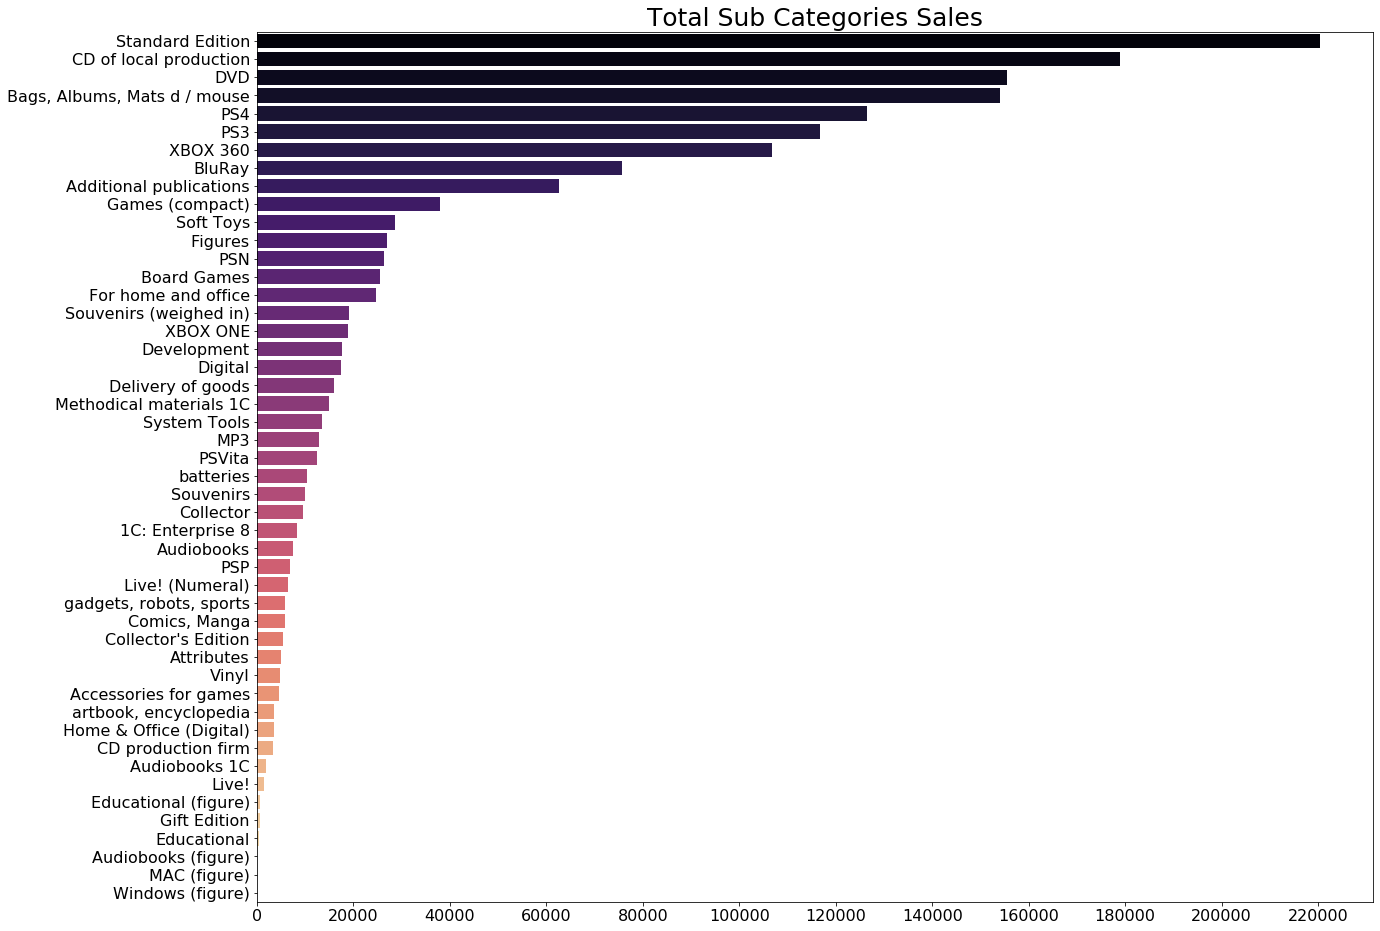

In [25]:
Z = merge1_Nodummies.groupby('category_subtype').agg({'item_cnt_month': sum}).sort_values(by='item_cnt_month',ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,16))
sns.barplot(data=Z, x='item_cnt_month', y='category_subtype', palette="magma",orient='h')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.title('Total Sub Categories Sales', fontsize=25)
plt.xticks([i for i in range(0, 240000, 20000)], fontsize=16);

--------------------

Monthly Sales per city 

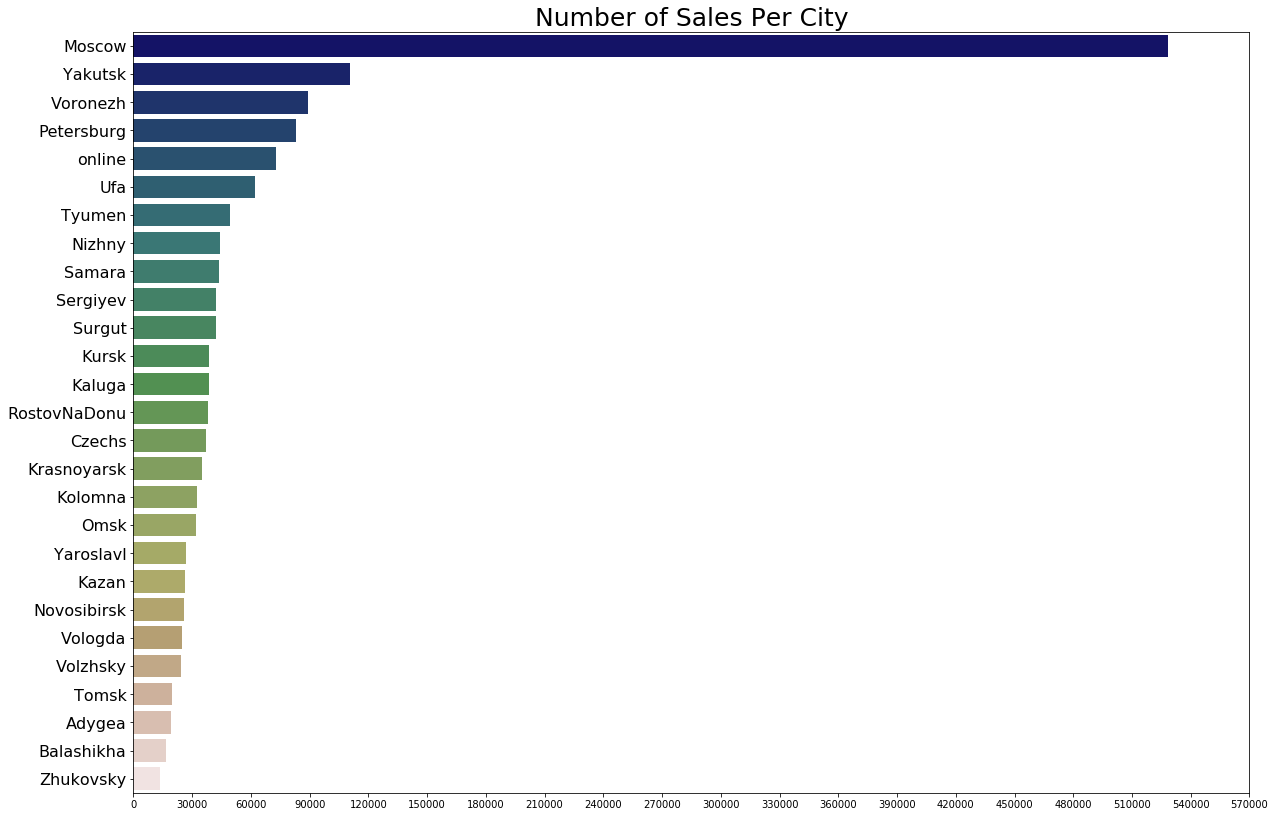

In [109]:
Z = merge1_Nodummies.groupby('city').agg({'item_cnt_month': sum}).sort_values('item_cnt_month', ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,14))
sns.barplot(data=Z, x='item_cnt_month', y='city', palette="gist_earth",orient='h')
plt.ylabel('')
plt.xlabel('')
plt.title('Number of Sales Per City', fontsize=25)
plt.yticks(fontsize=16)
plt.xticks([i for i in range(0, 600000, 30000)]);

--------------------

This graph shows change of sales per month 



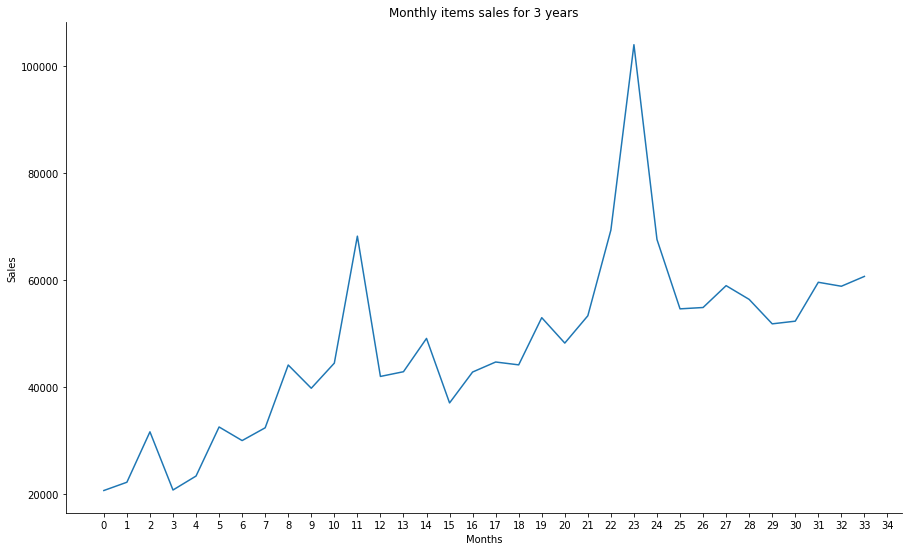

In [26]:
p = merge1_Nodummies.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index() 
g = sns.relplot(x="date_block_num", y="item_cnt_month",palette=["b", "r"], ci=None, kind="line", data=p)
g.fig.set_size_inches(15,8)
plt.title('Monthly items sales for 3 years')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.xticks([i for i in range(0, 35)]);

--------------------

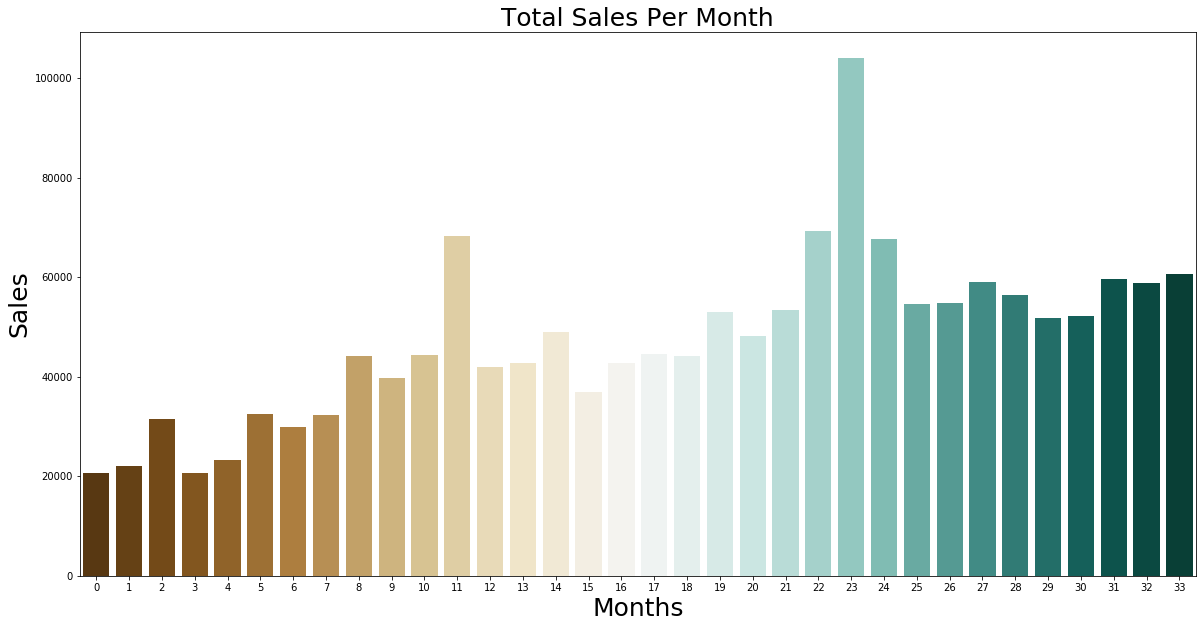

In [92]:
Z = merge1_Nodummies.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_cnt_month', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);

--------------------

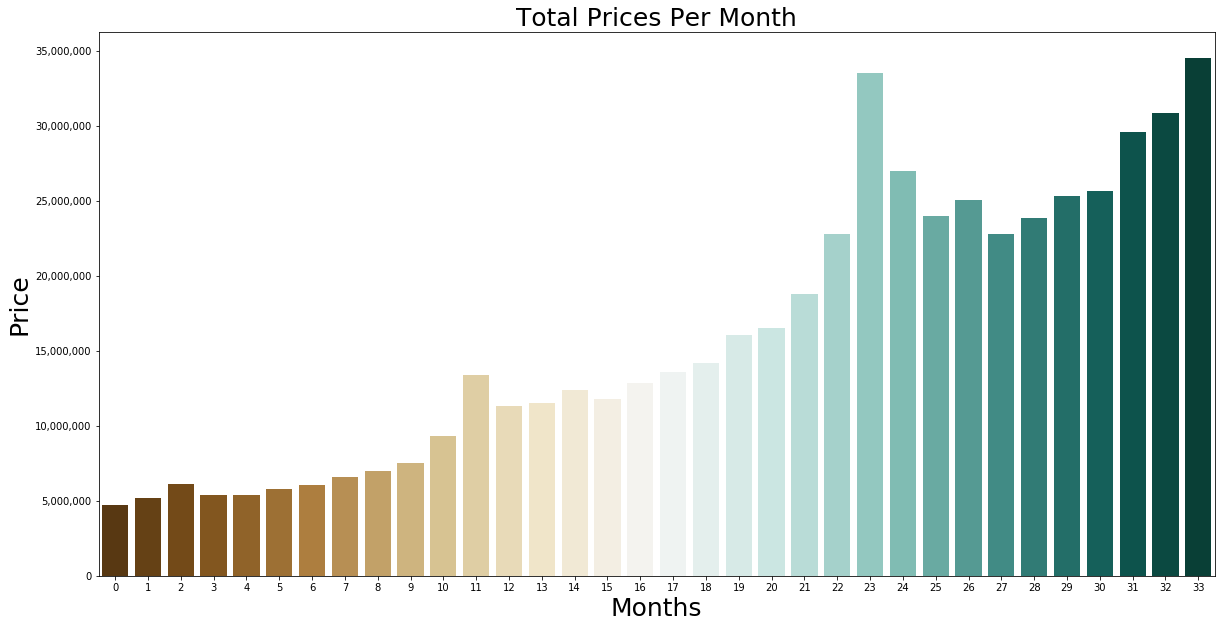

In [73]:
Z = merge1_Nodummies.groupby('date_block_num').agg({'item_avg_item_price': sum}).reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_avg_item_price', ax = ax, palette="BrBG")
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Total Prices Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Price', fontsize=25);

--------------------

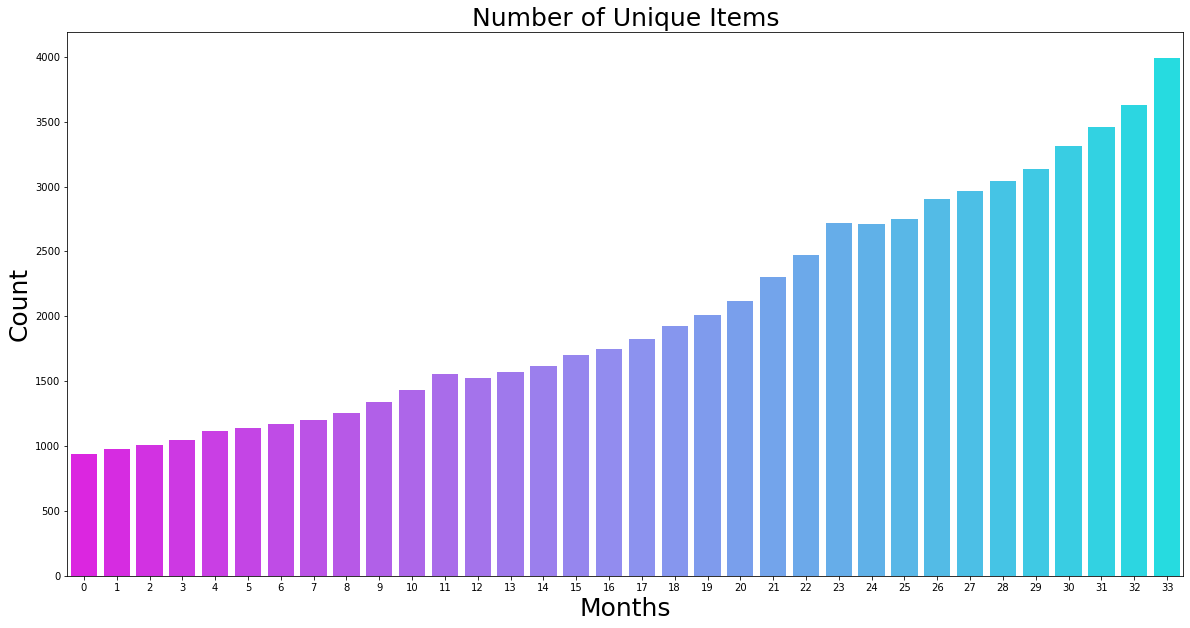

In [110]:
Z = merge1.groupby('date_block_num').agg({'item_id': 'nunique'}).reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_id', ax = ax, palette="cool_r")
plt.title('Number of Unique Items', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Count', fontsize=25);

--------------------

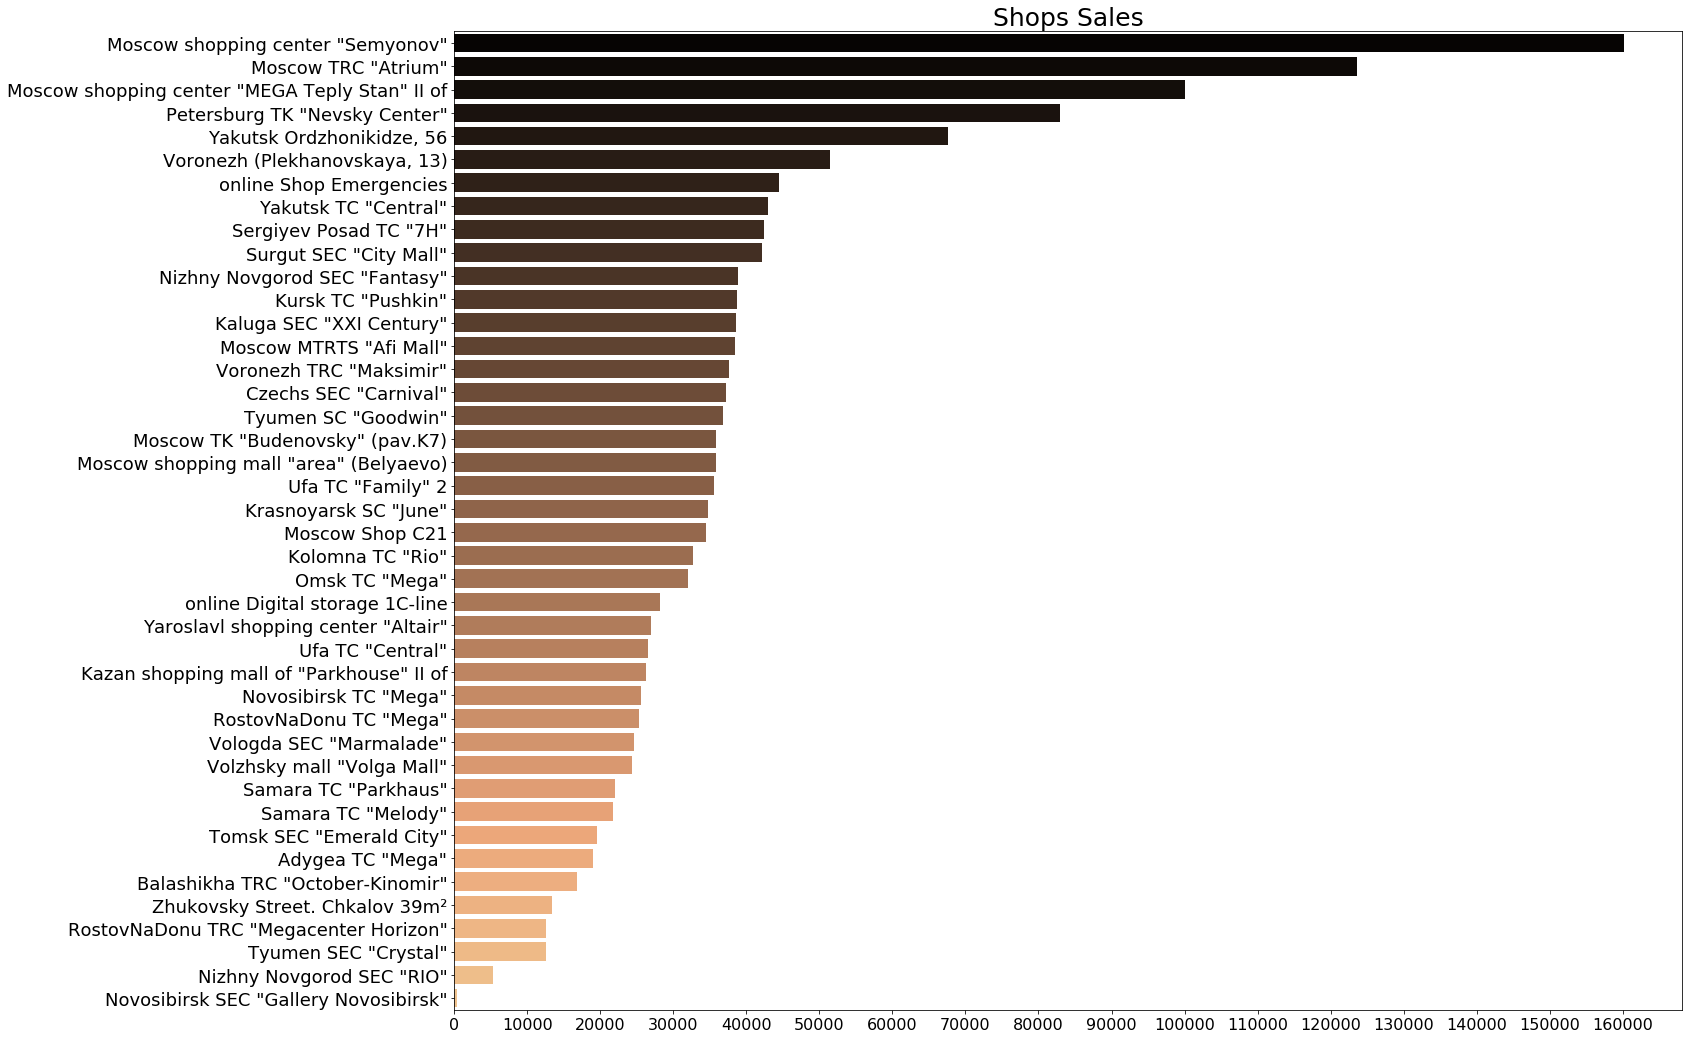

In [111]:
Z = merge1_Nodummies.groupby('shop_name').agg({'item_cnt_month': sum})\
    .sort_values(by='item_cnt_month', ascending=False).reset_index()
fig, ax = plt.subplots(figsize = (22,18))
sns.barplot(data=Z, x='item_cnt_month', y='shop_name', palette="copper",orient='h', ax=ax)
plt.title('Shops Sales', fontsize=25)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=18)
plt.xticks([i for i in range(0, 170000, 10000)], fontsize=16);

--------------------

<a id='the_destination_9'></a>
### 9. Dummies
##### Creating Dummies For Categorical Columns.

In [9]:
merge1 = pd.get_dummies(merge1, columns=['city','category_type','category_subtype'],drop_first=True)

to save memory uncomment the cell below , which will delete unneeded variables

In [5]:
# del df_catog
# del df_items
# del df_shops
# del df_sales_train0
# del merge2
# del merge1_Nodummies

drop unnecessary columns

In [10]:
merge1.drop(['date_shop_cat_avg_item_cnt' ,
             'date_avg_item_cnt' ,
             'date_item_avg_item_cnt',
             'date_shop_avg_item_cnt',
             'date_cat_avg_item_cnt','shop_name',
             'item_name',
             'ID',
             'item_avg_item_price',
             'date_item_avg_item_price',
             'date_shop_revenue',
             'shop_avg_revenue',
             'delta_revenue',
             'delta_revenue_lag_1'], axis=1, inplace=True)

we will remove first 12 months because we are using 12 as lag

In [11]:
merge1 = merge1[merge1['date_block_num'] > 11]

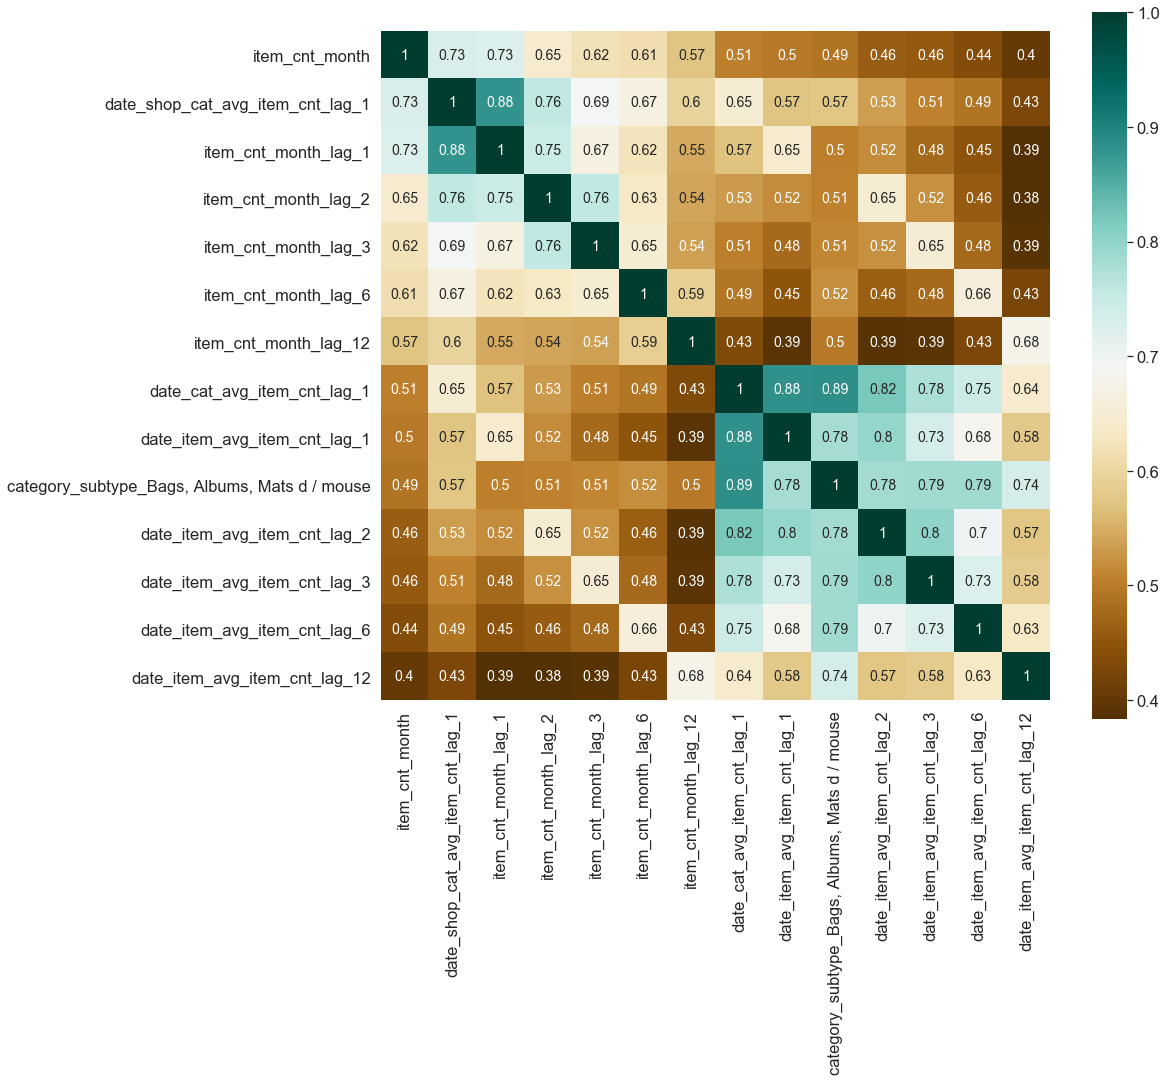

In [12]:
# Top Correlations

percent=0.20 
cor_train=merge1.corr()
high_corre = cor_train.index[abs(cor_train["item_cnt_month"])>percent]

#to sort columns from highest correlation with item_cnt_month
sorted_cols = cor_train.nlargest(len(high_corre),
'item_cnt_month')['item_cnt_month'].index 

plt.figure(figsize=(15,13))
sns.set(font_scale=1.5)

#plot heatmap with only the top features
nr_corr_matrix = sns.heatmap(merge1[sorted_cols].corr(),
annot=True,cmap="BrBG",square=True, annot_kws={'size':14})

<a id='the_destination_10'></a>

# 10. Modeling

In the evaluation section from the data provider they stated that the target in the test data is clipped to (0,20) so we did the same thing in the train data to get better results, we tried modeling without clipping and the results were bad, it seems clipping is better at handling outliers <br>
**Reference:** https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation
 

In [13]:
merge1['item_cnt_month'] = merge1['item_cnt_month'].clip(0,20)

In [9]:
X_plot= merge1[merge1['date_block_num'] < 34]

In [14]:
X = merge1[merge1['date_block_num'] < 34].drop(['item_cnt_month'], axis=1)
y = merge1[merge1['date_block_num']< 34]['item_cnt_month']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.1)

In [16]:
testing = merge1[merge1['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

<a id='the_destination_10.1'></a>

### 10.1 Xgboost

In [17]:
ts = time.time()

xgb_model = xgb.XGBRegressor(eta=0.01,
                                 max_depth=10,n_estimators=1000,
                                 colsample_bytree=0.5,
                                 subsample=0.8,
                                 gamma=2, reg_alpha=0, reg_lambda=2, min_child_weight=300,
                                 max_bin=2048,
                                 n_jobs=-1,
                                 tree_method='gpu_hist', gpu_id=0
                                 )

xgb_hist = xgb_model.fit(X_train,y_train,
                         eval_set=[(X_train,y_train),(X_test,y_test)],
                         eval_metric='rmse',
                         early_stopping_rounds=10)

# tree_method='gpu_hist', gpu_id=0
time.time() - ts

[0]	validation_0-rmse:1.54541	validation_1-rmse:1.55357
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.53836	validation_1-rmse:1.54647
[2]	validation_0-rmse:1.53257	validation_1-rmse:1.54064
[3]	validation_0-rmse:1.52578	validation_1-rmse:1.53375
[4]	validation_0-rmse:1.51868	validation_1-rmse:1.52661
[5]	validation_0-rmse:1.51158	validation_1-rmse:1.51946
[6]	validation_0-rmse:1.50428	validation_1-rmse:1.51213
[7]	validation_0-rmse:1.49776	validation_1-rmse:1.50554
[8]	validation_0-rmse:1.49137	validation_1-rmse:1.49910
[9]	validation_0-rmse:1.48494	validation_1-rmse:1.49260
[10]	validation_0-rmse:1.47815	validation_1-rmse:1.48576
[11]	validation_0-rmse:1.47208	validation_1-rmse:1.47968
[12]	validation_0-rmse:1.46524	validation_1-rmse:1.47281
[13]	validation_0-rmse:1.45878	validation_1-rmse:1.46630
[14]	validation_0-rmse:1.45234	validation_1-rmse:1.45

[141]	validation_0-rmse:1.08596	validation_1-rmse:1.09241
[142]	validation_0-rmse:1.08492	validation_1-rmse:1.09140
[143]	validation_0-rmse:1.08387	validation_1-rmse:1.09034
[144]	validation_0-rmse:1.08282	validation_1-rmse:1.08928
[145]	validation_0-rmse:1.08167	validation_1-rmse:1.08816
[146]	validation_0-rmse:1.08052	validation_1-rmse:1.08702
[147]	validation_0-rmse:1.07955	validation_1-rmse:1.08603
[148]	validation_0-rmse:1.07853	validation_1-rmse:1.08501
[149]	validation_0-rmse:1.07762	validation_1-rmse:1.08412
[150]	validation_0-rmse:1.07662	validation_1-rmse:1.08312
[151]	validation_0-rmse:1.07551	validation_1-rmse:1.08204
[152]	validation_0-rmse:1.07446	validation_1-rmse:1.08102
[153]	validation_0-rmse:1.07363	validation_1-rmse:1.08022
[154]	validation_0-rmse:1.07270	validation_1-rmse:1.07932
[155]	validation_0-rmse:1.07178	validation_1-rmse:1.07842
[156]	validation_0-rmse:1.07067	validation_1-rmse:1.07734
[157]	validation_0-rmse:1.06981	validation_1-rmse:1.07650
[158]	validati

[283]	validation_0-rmse:1.00731	validation_1-rmse:1.01636
[284]	validation_0-rmse:1.00700	validation_1-rmse:1.01605
[285]	validation_0-rmse:1.00667	validation_1-rmse:1.01576
[286]	validation_0-rmse:1.00647	validation_1-rmse:1.01558
[287]	validation_0-rmse:1.00625	validation_1-rmse:1.01538
[288]	validation_0-rmse:1.00598	validation_1-rmse:1.01511
[289]	validation_0-rmse:1.00562	validation_1-rmse:1.01478
[290]	validation_0-rmse:1.00537	validation_1-rmse:1.01455
[291]	validation_0-rmse:1.00497	validation_1-rmse:1.01419
[292]	validation_0-rmse:1.00476	validation_1-rmse:1.01400
[293]	validation_0-rmse:1.00459	validation_1-rmse:1.01383
[294]	validation_0-rmse:1.00443	validation_1-rmse:1.01367
[295]	validation_0-rmse:1.00422	validation_1-rmse:1.01346
[296]	validation_0-rmse:1.00398	validation_1-rmse:1.01323
[297]	validation_0-rmse:1.00377	validation_1-rmse:1.01302
[298]	validation_0-rmse:1.00358	validation_1-rmse:1.01283
[299]	validation_0-rmse:1.00330	validation_1-rmse:1.01259
[300]	validati

[425]	validation_0-rmse:0.98455	validation_1-rmse:0.99559
[426]	validation_0-rmse:0.98450	validation_1-rmse:0.99555
[427]	validation_0-rmse:0.98437	validation_1-rmse:0.99544
[428]	validation_0-rmse:0.98433	validation_1-rmse:0.99539
[429]	validation_0-rmse:0.98421	validation_1-rmse:0.99530
[430]	validation_0-rmse:0.98413	validation_1-rmse:0.99524
[431]	validation_0-rmse:0.98405	validation_1-rmse:0.99518
[432]	validation_0-rmse:0.98389	validation_1-rmse:0.99504
[433]	validation_0-rmse:0.98383	validation_1-rmse:0.99499
[434]	validation_0-rmse:0.98375	validation_1-rmse:0.99491
[435]	validation_0-rmse:0.98373	validation_1-rmse:0.99489
[436]	validation_0-rmse:0.98368	validation_1-rmse:0.99486
[437]	validation_0-rmse:0.98359	validation_1-rmse:0.99479
[438]	validation_0-rmse:0.98351	validation_1-rmse:0.99471
[439]	validation_0-rmse:0.98340	validation_1-rmse:0.99461
[440]	validation_0-rmse:0.98332	validation_1-rmse:0.99454
[441]	validation_0-rmse:0.98328	validation_1-rmse:0.99449
[442]	validati

[567]	validation_0-rmse:0.97333	validation_1-rmse:0.98568
[568]	validation_0-rmse:0.97326	validation_1-rmse:0.98562
[569]	validation_0-rmse:0.97320	validation_1-rmse:0.98556
[570]	validation_0-rmse:0.97312	validation_1-rmse:0.98548
[571]	validation_0-rmse:0.97308	validation_1-rmse:0.98545
[572]	validation_0-rmse:0.97304	validation_1-rmse:0.98541
[573]	validation_0-rmse:0.97302	validation_1-rmse:0.98539
[574]	validation_0-rmse:0.97297	validation_1-rmse:0.98535
[575]	validation_0-rmse:0.97294	validation_1-rmse:0.98533
[576]	validation_0-rmse:0.97291	validation_1-rmse:0.98530
[577]	validation_0-rmse:0.97288	validation_1-rmse:0.98527
[578]	validation_0-rmse:0.97281	validation_1-rmse:0.98523
[579]	validation_0-rmse:0.97272	validation_1-rmse:0.98516
[580]	validation_0-rmse:0.97266	validation_1-rmse:0.98510
[581]	validation_0-rmse:0.97257	validation_1-rmse:0.98502
[582]	validation_0-rmse:0.97255	validation_1-rmse:0.98500
[583]	validation_0-rmse:0.97253	validation_1-rmse:0.98498
[584]	validati

[709]	validation_0-rmse:0.96749	validation_1-rmse:0.98064
[710]	validation_0-rmse:0.96747	validation_1-rmse:0.98063
[711]	validation_0-rmse:0.96745	validation_1-rmse:0.98061
[712]	validation_0-rmse:0.96737	validation_1-rmse:0.98055
[713]	validation_0-rmse:0.96734	validation_1-rmse:0.98052
[714]	validation_0-rmse:0.96731	validation_1-rmse:0.98050
[715]	validation_0-rmse:0.96730	validation_1-rmse:0.98049
[716]	validation_0-rmse:0.96721	validation_1-rmse:0.98042
[717]	validation_0-rmse:0.96715	validation_1-rmse:0.98036
[718]	validation_0-rmse:0.96710	validation_1-rmse:0.98033
[719]	validation_0-rmse:0.96708	validation_1-rmse:0.98031
[720]	validation_0-rmse:0.96707	validation_1-rmse:0.98030
[721]	validation_0-rmse:0.96704	validation_1-rmse:0.98027
[722]	validation_0-rmse:0.96702	validation_1-rmse:0.98026
[723]	validation_0-rmse:0.96701	validation_1-rmse:0.98024
[724]	validation_0-rmse:0.96697	validation_1-rmse:0.98021
[725]	validation_0-rmse:0.96694	validation_1-rmse:0.98018
[726]	validati

[851]	validation_0-rmse:0.96313	validation_1-rmse:0.97710
[852]	validation_0-rmse:0.96308	validation_1-rmse:0.97705
[853]	validation_0-rmse:0.96306	validation_1-rmse:0.97704
[854]	validation_0-rmse:0.96304	validation_1-rmse:0.97702
[855]	validation_0-rmse:0.96303	validation_1-rmse:0.97700
[856]	validation_0-rmse:0.96300	validation_1-rmse:0.97698
[857]	validation_0-rmse:0.96295	validation_1-rmse:0.97693
[858]	validation_0-rmse:0.96281	validation_1-rmse:0.97682
[859]	validation_0-rmse:0.96280	validation_1-rmse:0.97681
[860]	validation_0-rmse:0.96277	validation_1-rmse:0.97678
[861]	validation_0-rmse:0.96272	validation_1-rmse:0.97675
[862]	validation_0-rmse:0.96264	validation_1-rmse:0.97668
[863]	validation_0-rmse:0.96262	validation_1-rmse:0.97666
[864]	validation_0-rmse:0.96261	validation_1-rmse:0.97665
[865]	validation_0-rmse:0.96259	validation_1-rmse:0.97663
[866]	validation_0-rmse:0.96257	validation_1-rmse:0.97662
[867]	validation_0-rmse:0.96255	validation_1-rmse:0.97661
[868]	validati

[993]	validation_0-rmse:0.95880	validation_1-rmse:0.97363
[994]	validation_0-rmse:0.95877	validation_1-rmse:0.97361
[995]	validation_0-rmse:0.95874	validation_1-rmse:0.97358
[996]	validation_0-rmse:0.95872	validation_1-rmse:0.97357
[997]	validation_0-rmse:0.95871	validation_1-rmse:0.97356
[998]	validation_0-rmse:0.95868	validation_1-rmse:0.97354
[999]	validation_0-rmse:0.95864	validation_1-rmse:0.97351


228.24866557121277

In [19]:
y_predV = xgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_predV)))
y_pred = xgb_model.predict(testing)

0.973509362709309


In [22]:
print('Train Score:', xgb_model.score(X_train, y_train))
print('Test Score :', xgb_model.score(X_test, y_test))

Train Score: 0.6187901283012218
Test Score : 0.6110416291265268


In [20]:
cv=KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_score(xgb_model, X, y, cv=cv).mean()

0.6023323386934785

## After testing a lot of models, and after parameters tuning, we found that XGBoost is the best model

## Visualizing XGBoost results

In [37]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

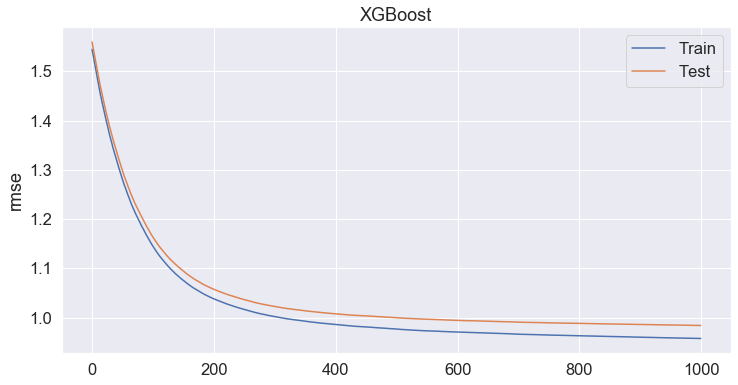

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost')
plt.show()

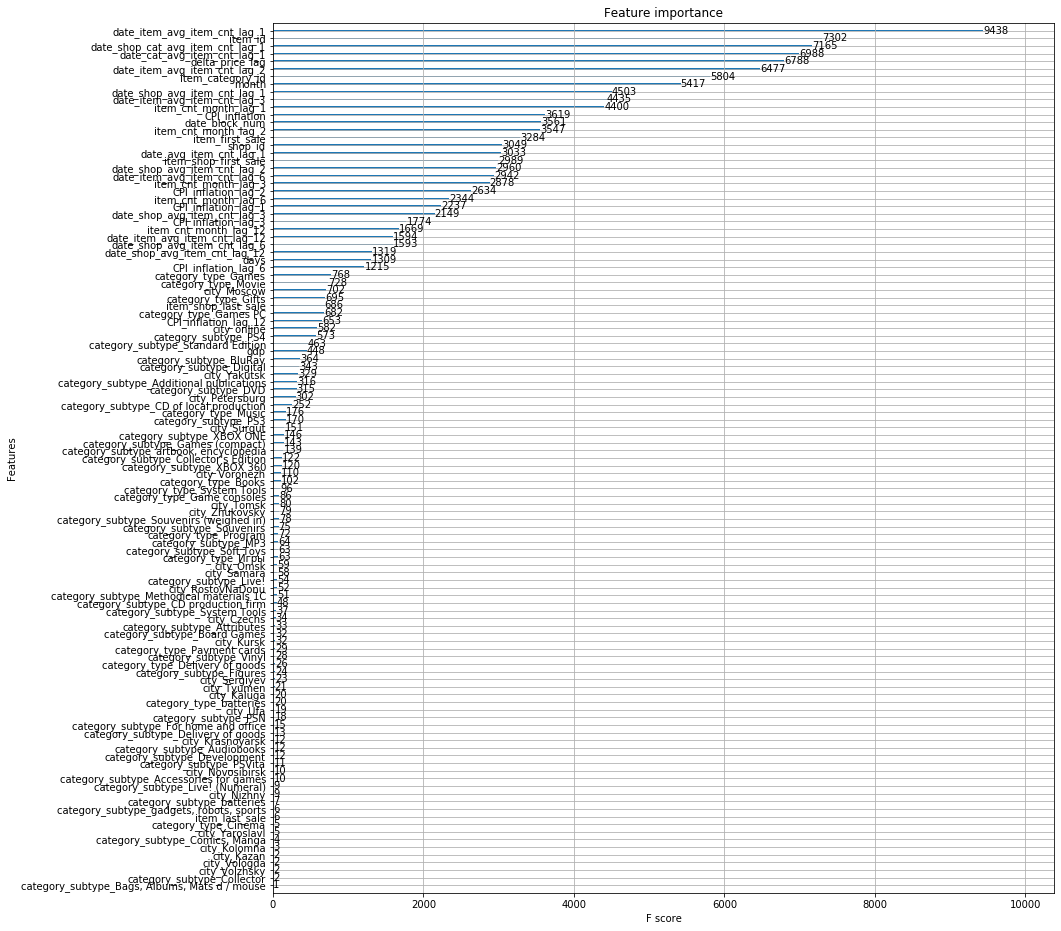

In [15]:
fig, ax = plt.subplots(figsize=(14,16))
xgb.plot_importance(xgb_model, ax)

Here are the predicted top 10 items we expect to have high sales in the next month

In [66]:
#here we will get item_name from date_block_number 33 (month 33) 
y_predV_Df_test = pd.DataFrame({'item_id' : X_test['item_id'],'shop_id' : X_test['shop_id'] ,'item_cnt_month' : y_predV  }) 
top_10_items = y_predV_Df_test.sort_values(by='item_cnt_month' , ascending=False).head(20)
top_10_items['date_block_num'] = 33 
item_name = []
for i in top_10_items['item_id'].values:
    
    top = pd.merge(top_10_items,merge1[['item_name' , 'item_id','shop_id','date_block_num']],on=['item_id','shop_id','date_block_num'],how='left')#
    
top['date_block_num'] = 34

In [83]:
top.head(10)

item_id  shop_id  item_cnt_month  date_block_num  \
0     5822       31       23.171303              34   
1    17717       24       23.132126              34   
2    17717       28       21.753023              34   
3     5822       31       21.303637              34   
4    17717       59       21.267839              34   
5     4181       15       21.258093              34   
6     5822       15       21.233402              34   
7      492       55       20.990267              34   
8     7967       55       20.987103              34   
9     4181       15       20.962862              34   

                                           item_name  
0  Playstation Store replenishment wallet: Map pa...  
1                         Receiving cash for 1C-line  
2                         Receiving cash for 1C-line  
3  Playstation Store replenishment wallet: Map pa...  
4                         Receiving cash for 1C-line  
5  Kaspersky Internet Security Multi-Device Russi...  
6  Playstation Store replenishment wallet: Map pa...  
7  1С:Деньги 8 Электронная версия [PC, Цифровая в...  
8  Xbox LIVE: GOLD subscription card 3 months [Di...  
9  Kaspersky Internet Security Multi-Device Russi...

### Compairing the actual values with predicted values

In [25]:
y_predV_Df = pd.DataFrame({'date_block_num' : X_test['date_block_num'] ,'item_cnt_month' : y_predV  })

In [22]:
y_test_Df = pd.DataFrame({'date_block_num' : X_test['date_block_num'] ,'item_cnt_month' : y_test  })

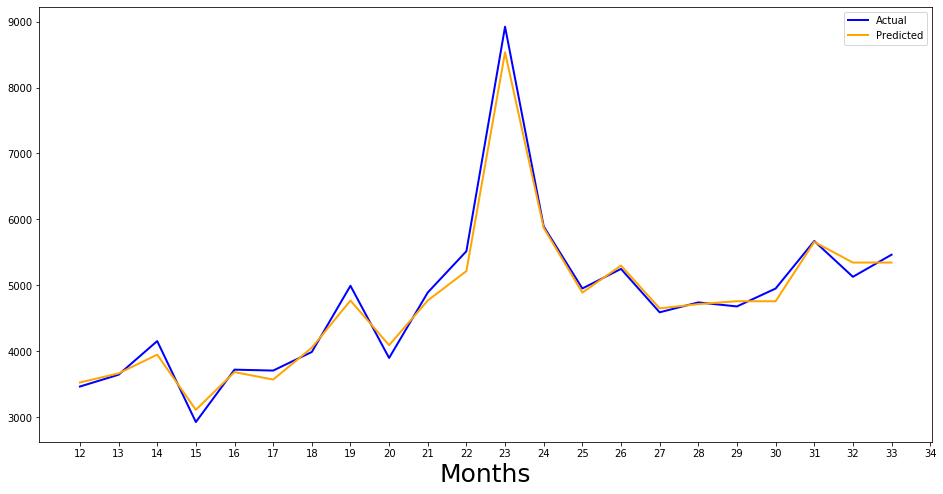

In [29]:
fig , ax = plt.subplots(ncols=1 , figsize=(16,8))
xl = y_test_Df.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
y_predsum = y_predV_Df.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
xl.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax ,  linewidth=2 , c='b')
y_predsum.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax , linewidth=2 , c='orange' )
plt.legend(['Actual' , 'Predicted'])
plt.xlabel('Months' , fontsize=25)
# y_predsum.plot(x='date_block_num',y='item_cnt_month', kind='line' , ax=ax)
ax.set_xticks([i for i in range(12, 35)]);
# ax.set_yticks([i for i in range(0, 20000, 3000)]);

### Ploting the train and predicted test

In [15]:
y_predDf = pd.DataFrame({'date_block_num' : 34 ,'item_cnt_month' : y_pred  })
xl = X_plot.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
mk = pd.concat([xl, y_predsum])

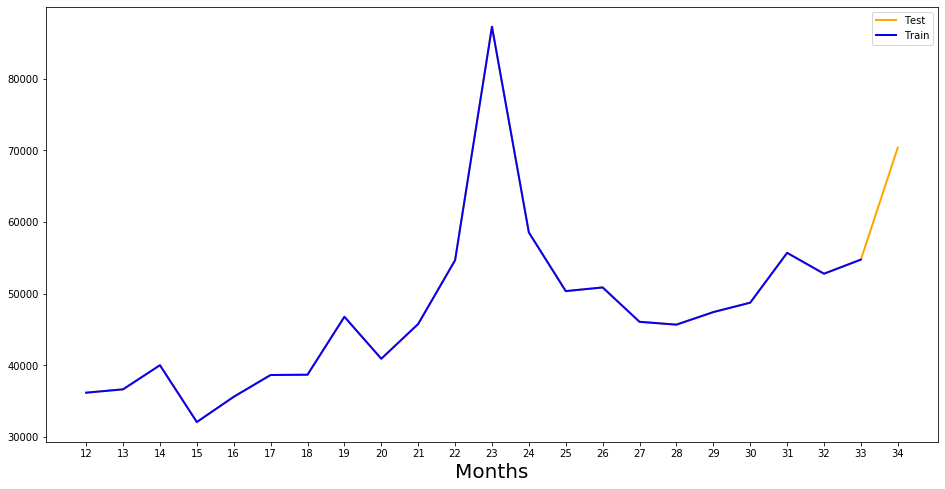

In [30]:
fig , ax = plt.subplots(ncols=1 , figsize=(16,8))
xl = X_plot.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
y_predsum = y_predDf.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
mk.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax ,  linewidth=2 , c='orange')
xl.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax , linewidth=2 , c='b' )
ax.legend(['Test' , 'Train'])
plt.xlabel('Months' , fontsize=20)
# y_predsum.plot(x='date_block_num',y='item_cnt_month', kind='line' , ax=ax)
ax.set_xticks([i for i in range(12, 35)]);

### also Ploting the train and predicted test

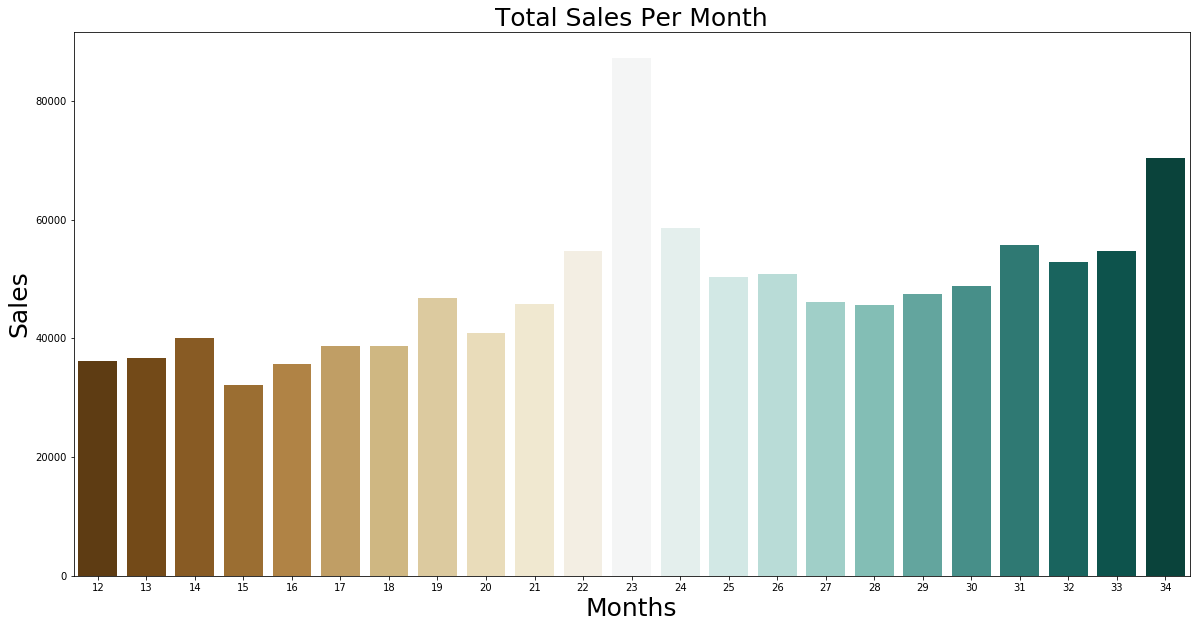

In [31]:
# xl = X_plot.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
# y_predsum = y_predDf.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=mk, x='date_block_num', y='item_cnt_month', ax = ax, palette="BrBG")
# sns.barplot(data=y_predsum, x='date_block_num', y='item_cnt_month', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);

<a id='the_destination_10.2'></a>

### 10.2 Sequential model

In [209]:
Seq_model = Sequential()
Seq_model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1] ))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))


Seq_model.add(Dense(1))

In [210]:
Seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 129)               16770     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                6500      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_21 (Dense)             (None, 50)               

In [211]:
opt = Adam(lr=.001)

In [212]:
Seq_model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [214]:
ts = time.time()



Seq_hist = Seq_model.fit(X_train,
                          y_train,
                         validation_data = (X_test, y_test),
                         batch_size=10000,
                         epochs = 40)
time.time() - ts

Train on 2031305 samples, validate on 225701 samples
Epoch 1/40
2031305/2031305 [==============================] - 11s 5us/step - loss: 28.2200 - root_mean_squared_error: 9.6558 - val_loss: 2.9591 - val_root_mean_squared_error: 5.1797
Epoch 2/40
2031305/2031305 [==============================] - 10s 5us/step - loss: 2.1643 - root_mean_squared_error: 4.3371 - val_loss: 1.8994 - val_root_mean_squared_error: 3.7691
Epoch 3/40
2031305/2031305 [==============================] - 10s 5us/step - loss: 1.8901 - root_mean_squared_error: 3.4327 - val_loss: 1.5266 - val_root_mean_squared_error: 3.1668
Epoch 4/40
2031305/2031305 [==============================] - 9s 5us/step - loss: 3.3688 - root_mean_squared_error: 2.9931 - val_loss: 1.9398 - val_root_mean_squared_error: 2.8814
Epoch 5/40
2031305/2031305 [==============================] - 9s 5us/step - loss: 1.7317 - root_mean_squared_error: 2.7549 - val_loss: 1.5377 - val_root_mean_squared_error: 2.6411
Epoch 6/40
2031305/2031305 [===============

398.95468854904175

In [219]:
y_pred = Seq_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = Seq_model.predict(testing)

1.183571919257938


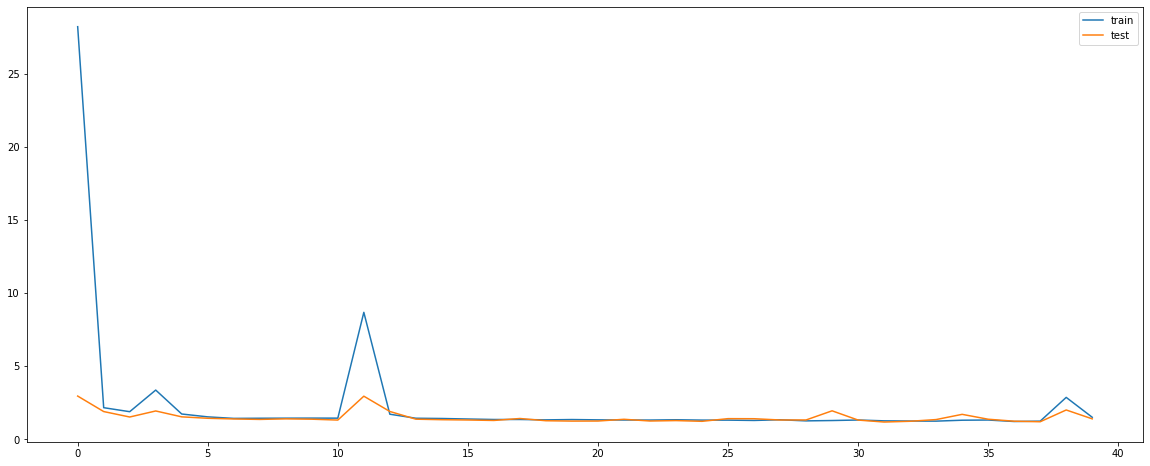

In [217]:
## plot loss function
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(Seq_hist.history['loss'], label='train')
plt.plot(Seq_hist.history['val_loss'], label='test')
plt.legend()

<a id='the_destination_10.3'></a>

### 10.3 LSTM

In [ ]:
ss = StandardScaler()
sX_train =ss.fit_tranX_torm(X_train)
sX_test =ss.transform(X_test)
stesting=ss.transform(testing)

In [193]:
X_train1 = np.reshape(sX_train, (sX_train.shape[0], 1, sX_train.shape[1]))
X_test1 = np.reshape(sX_test, (sX_test.shape[0], 1, sX_test.shape[1]))

In [194]:
lstm_model = Sequential()
lstm_model.add(LSTM(X_train.shape[1], input_dim=X_train.shape[1]))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(1))


lstm_model.compile(loss='mse', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [195]:
ts = time.time()

lstm_model.fit(X_train1, y_train,
               validation_data=(X_test1, y_test),
               epochs=50,
               shuffle=False,
               batch_size=4000,
               verbose=1)
time.time() - ts

Train on 2031305 samples, validate on 225701 samples
Epoch 1/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.2281 - root_mean_squared_error: 1.1679 - val_loss: 1.1798 - val_root_mean_squared_error: 1.1070
Epoch 2/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.1240 - root_mean_squared_error: 1.0941 - val_loss: 1.1367 - val_root_mean_squared_error: 1.0840
Epoch 3/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.0926 - root_mean_squared_error: 1.0774 - val_loss: 1.1058 - val_root_mean_squared_error: 1.0715
Epoch 4/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 1.0710 - root_mean_squared_error: 1.0669 - val_loss: 1.0819 - val_root_mean_squared_error: 1.0626
Epoch 5/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 1.0544 - root_mean_squared_error: 1.0590 - val_loss: 1.0669 - val_root_mean_squared_error: 1.0557s: 1.0553 - root_mean_squared_error: 1

Epoch 45/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 0.8495 - root_mean_squared_error: 0.9754 - val_loss: 0.9576 - val_root_mean_squared_error: 0.9749
Epoch 46/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 0.8470 - root_mean_squared_error: 0.9744 - val_loss: 0.9597 - val_root_mean_squared_error: 0.9739
Epoch 47/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 0.8448 - root_mean_squared_error: 0.9734 - val_loss: 0.9612 - val_root_mean_squared_error: 0.9729
Epoch 48/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 0.8422 - root_mean_squared_error: 0.9724 - val_loss: 0.9619 - val_root_mean_squared_error: 0.9719
Epoch 49/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 0.8398 - root_mean_squared_error: 0.9714 - val_loss: 0.9622 - val_root_mean_squared_error: 0.9709
Epoch 50/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 

1236.8428268432617

In [196]:
testing1 = np.reshape(stesting, (stesting.shape[0], 1, stesting.shape[1]))

In [197]:
y_pred = lstm_model.predict(X_test1)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = lstm_model.predict(testing1)

0.9787841087700061


<a id='the_destination_10.4'></a>

### 10.4 Random Forest Regressor Model

In [199]:
randomF = RandomForestRegressor(verbose=1 , n_jobs=-1)
randomF.fit(X_train, y_train)
print('Train Score:', randomF.score(X_train, y_train))
print('Test Score :', randomF.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 36.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.2s finished


Train Score: 0.9527156510154877


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s


Test Score : 0.6117348143124118


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


In [200]:
y_pred = randomF.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = randomF.predict(testing)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


0.9566374244810614


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


<a id='the_destination_10.5'></a>

### 10.5 LinearRegression

In [188]:
ts = time.time()
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
print('Train Score:',lr.score(X_train, y_train))
print('Test Score :',lr.score(X_test, y_test))
time.time() - ts

Train Score: 0.3213200444513007
Test Score : 0.3141071367930006


8.979910373687744

In [189]:
y_pred = lr.predict(X_test).clip(0, 20)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = lr.predict(testing).clip(0, 20)

1.244300825618995


<a id='the_destination_10.6'></a>

## 10.6 Ridge

In [182]:
ts = time.time()
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Train Score:', ridge.score(X_train, y_train))
print('Test Score :', ridge.score(X_test, y_test))
time.time() - ts

Train Score: 0.3213197537822817
Test Score : 0.31411134567117105


3.301731824874878

In [183]:
y_pred = ridge.predict(X_test).clip(0, 20)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = ridge.predict(testing).clip(0, 20)

1.244293353333927


<a id='the_destination_11'></a>

### 11. Submission

In [32]:
thesubmission = df.copy()
thesubmission['item_cnt_month'] = y_pred.clip(0,20)
thesubmission.to_csv('Xgboostlastone.csv', index=False)
thesubmission['item_cnt_month'].head()

0    0.778714
1    0.513518
2    1.318009
3    0.504726
4    2.168962
Name: item_cnt_month, dtype: float32

<a id='the_destination_12'></a>

# 12.Evaluation

Here submissions are evaluated by root mean squared error (RMSE). <br>
True target values are clipped into [0,20] range. <br>
<br>
Best model<br>
Model:             XGBoost<br>
Runtime:           3 Minutes<br>
kaggle Score(RMSE):       0.91


<a id='the_destination_13'></a>

# 13. Conclusion and Recommendations

After we saw that the sales well increase in November, we advise the shops to expect a lot of customers ,
also after analyzing the data we noticed that over 65% of the sales come from entertainment sector, also our model expect that 4 of the top 10 selling items in the next month will come from the entertainment sector
So we recommend shops in the entertainment sector to be ready for high demand from customers

<a id='the_destination_14'></a>

# 14. References

Datasets : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data <br>
CPI: Consumer price index : https://www.inflation.eu/inflation-rates/russia/historic-inflation/cpi-inflation-russia.aspx <br>
Russia GDP Per Capita : https://www.macrotrends.net/countries/RUS/russia/gdp-per-capita